# RoBERTa - Modelo HuggingFace preentrenado TF 

Tratando de mejorar la primera implementación de BERT con DistilBERT, usaremos el modelo entrenado de RoBERTa y la librería transformers. El modelo pre-entrenado de RoBERTa elegido será dla implementación de HuggingFace preentrenado en tensorflow..

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import re 
import string
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Flatten,Embedding,Lambda,Dropout,LSTM,Conv1D,Concatenate,Add
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import keras.backend as K

In [2]:
!pip install transformers

In [3]:
from transformers import  RobertaConfig, TFRobertaModel
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.models import BPE
from tokenizers.normalizers import Lowercase, NFKC, Sequence
from tokenizers.pre_tokenizers import ByteLevel

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
train=pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
#Referencia https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert

def clean(tweet):
    tweet = str(tweet)

    tweet=tweet.lower()

    #Remove html tags
    tweet=re.sub('<.*?>','',tweet)

    #Remove text in square brackets
    tweet=re.sub('\[.*?\]','',tweet)

    #Remove hyperlinks
    tweet=re.sub('https?://\S+|www\.\S+','',tweet)


    return tweet

In [6]:
train.dropna(inplace = True)
train["text"] = train["text"].apply(lambda x : x.strip())
train["selected_text"] = train["selected_text"].apply(lambda x : x.strip())

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train,train['sentiment'],
                                              test_size=0.2,random_state=42,stratify=train['sentiment'])
X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train shape',X_train.shape,' Y_train shape ',Y_train.shape)
print('X_val shape',X_val.shape,' Y_val shape ',Y_val.shape)
print('X_test shape',X_test.shape,' Y_test shape ',Y_test.shape)

X_train shape (17587, 4)  Y_train shape  (17587,)
X_val shape (5496, 4)  Y_val shape  (5496,)
X_test shape (4397, 4)  Y_test shape  (4397,)


In [8]:

# Definición de variables generales
MAX_LEN = 128
tokenizer = Tokenizer(BPE.from_file('../input/tf-roberta/vocab-roberta-base.json', '../input/tf-roberta/merges-roberta-base.txt'))
tokenizer.pre_tokenizer = ByteLevel()
tokenizer.decoder = ByteLevelDecoder()

In [9]:
resPos = tokenizer.encode('How I new that thing')
resNeg = tokenizer.encode('negative')
resNeu = tokenizer.encode('neutral')

In [10]:
print(f'Representación ID positive: {resPos.ids}')
print(f'Representación ID negative: {resNeg.ids}')
print(f'Representación ID neutral: {resNeu.ids}')

Representación ID positive: [1336, 38, 92, 14, 631]
Representación ID negative: [2430]
Representación ID neutral: [7974]


In [11]:
tokenizer.decode(resPos.ids)

' How I new that thing'

In [12]:
# Definición de sentimientos basados en el diccionario de RoBERTa
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [13]:

#Referencia: https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705

def createInputData(data,tokenizer):

    row = data.shape[0]
    input_ids = np.ones((row,MAX_LEN),dtype='int32')
    attention_mask = np.zeros((row,MAX_LEN),dtype='int32')
    token_type_ids = np.zeros((row,MAX_LEN),dtype='int32')
    start_tokens = np.zeros((row,MAX_LEN),dtype='int32')
    end_tokens = np.zeros((row,MAX_LEN),dtype='int32')

    for k in range(data.shape[0]):
        # Búsqueda del indice inicial
        text1 = " "+" ".join(data.loc[k,'text'].split())
        text2 = " ".join(data.loc[k,'selected_text'].split())
        idx = text1.find(text2)
        # Selección de las posiciones que ocupan los textos
        chars = np.zeros((len(text1)))
        chars[idx:idx+len(text2)]=1

        if text1[idx-1]==' ': 
            chars[idx-1] = 1 

        # Codificación del texto completo
        enc = tokenizer.encode(text1) 

        # Encuentro de offsets
        token_offsets=[]
        idx=0
        for i in enc.ids:
            word=tokenizer.decode([i])
            token_offsets.append((idx,idx+len(word)))
            idx+=len(word)

        # Definición de tokens de inicio y finalización
        target_idx = []
        for i,(o1,o2) in enumerate(token_offsets):
            if(sum(chars[o1:o2])>0):
                target_idx.append(i)  
        s_tok = sentiment_id[data.loc[k,'sentiment']]

        input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
        attention_mask[k,:len(enc.ids)+5] = 1

        #Se adiciona 1 a los tokens
        if len(target_idx)>0:
            start_tokens[k,target_idx[0]+1] = 1
            end_tokens[k,target_idx[-1]+1] = 1

    return (input_ids,attention_mask,token_type_ids,start_tokens,end_tokens)

In [14]:
#Convertir los datos de validación y pruebas en la entrada de RoBERTa
X_tr1,X_tr2,X_tr3,Y_tr1,Y_tr2=createInputData(X_train,tokenizer)
X_val1,X_val2,X_val3,Y_val1,Y_val2=createInputData(X_val,tokenizer)
X_te1,X_te2,X_te3,Y_te1,Y_te2=createInputData(X_test,tokenizer)

In [15]:
# Arquitectura de red reunal con RoBERTa
def build_model():
    '''Builds the model'''

    ids=Input((MAX_LEN),name='ids',dtype='int32')
    att_mask=Input((MAX_LEN),name='att_mask',dtype='int32')
    type_ids=Input((MAX_LEN),name='type_ids',dtype='int32')

    roberta_conf = RobertaConfig.from_pretrained('roberta-base')
    roberta_model = TFRobertaModel.from_pretrained('roberta-base',config=roberta_conf)

    bert_output=roberta_model([ids,att_mask,type_ids])

    dropout1=Dropout(0.1,name='dropout1')(bert_output[0])
    conv1d_1 = Conv1D(1,1,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),name='conv1d_1')(dropout1)
    flatten_1 = Flatten(name='flatten_1')(conv1d_1)
    out_1 = tf.keras.layers.Activation('softmax',name='activation1')(flatten_1)

    dropout2=Dropout(0.1,name='dropout2')(bert_output[0])
    conv1d_2 = Conv1D(1,1,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),name='conv1d_2')(dropout2)
    flatten_2 = Flatten(name='flatten_2')(conv1d_2)
    out_2 = tf.keras.layers.Activation('softmax',name='activation2')(flatten_2)

    model1 = Model(inputs=[ids, att_mask, type_ids], outputs=[out_1,out_2])

    return model1
  
model=build_model()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ids (InputLayer)                [(None, 128)]        0                                            
__________________________________________________________________________________________________
att_mask (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
type_ids (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 128, 768), ( 124645632   ids[0][0]                        
                                                                 att_mask[0][0]        

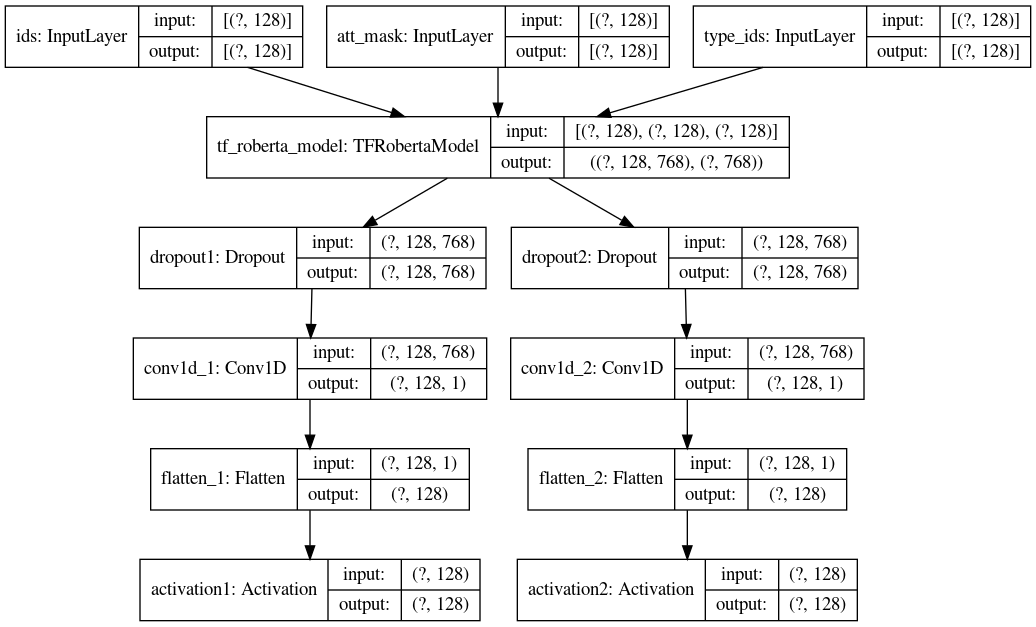

In [17]:
tf.keras.utils.plot_model(model, './ModeloRobertaRN.png',show_shapes=True)

In [18]:
import os
if not os.path.exists('./model-roberta'):
    os.makedirs('./model-roberta')

In [19]:
# Parámetros de RoBERTA para tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf ./logs/ 

log_dir='./model-roberta'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint('./model-roberta/roberta.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')

In [21]:
# Compilación del modelo con optimizador Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [22]:
# Entrenamiento del modelo
callback=[tensorboard_callback,checkpoint]
model.fit([X_tr1,X_tr2,X_tr3],[Y_tr1,Y_tr2],
           validation_data=([X_val1,X_val2,X_val3],[Y_val1,Y_val2]),
           batch_size=32,epochs=4,callbacks=callback)

Epoch 1/4
550/550 [==============================] - ETA: 0s - loss: 2.5119 - activation1_loss: 1.2489 - activation2_loss: 1.2631
Epoch 00001: val_loss improved from inf to 1.73993, saving model to ./model-roberta/roberta.h5
550/550 [==============================] - 308s 559ms/step - loss: 2.5119 - activation1_loss: 1.2489 - activation2_loss: 1.2631 - val_loss: 1.7399 - val_activation1_loss: 0.8738 - val_activation2_loss: 0.8662
Epoch 2/4
550/550 [==============================] - ETA: 0s - loss: 1.6740 - activation1_loss: 0.8634 - activation2_loss: 0.8106
Epoch 00002: val_loss improved from 1.73993 to 1.64777, saving model to ./model-roberta/roberta.h5
550/550 [==============================] - 306s 556ms/step - loss: 1.6740 - activation1_loss: 0.8634 - activation2_loss: 0.8106 - val_loss: 1.6478 - val_activation1_loss: 0.8504 - val_activation2_loss: 0.7974
Epoch 3/4
550/550 [==============================] - ETA: 0s - loss: 1.5029 - activation1_loss: 0.7768 - activation2_loss: 0.726

In [23]:
# Predecir con los datos de texto
start,end=model.predict([X_te1,X_te2,X_te3])

In [24]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [25]:

def find_selected_text(data,tokenizer,start,end):
    '''Finds the selected text for the given tweet'''
    selected_text_list=[]
    for i in range(data.shape[0]):

        # Búsqueda de index
        start_idx=np.argmax(start[i])
        end_idx=np.argmax(end[i])


        # Encuentra el texto de la predicción a partir de los indices
        if (start_idx>end_idx):
            predicted_text=data.loc[i,'text']

        else:
            text1 = " "+" ".join(data.loc[i,'text'].split())
            tokens=tokenizer.encode(text1)
            predicted_text=tokenizer.decode(tokens.ids[start_idx-1:end_idx])        

        selected_text_list.append(predicted_text)

    return selected_text_list
    


In [26]:
selected_text=find_selected_text(X_test,tokenizer,start,end)
X_test['predicted_text']=selected_text

for i,(_,row) in enumerate(X_test.iterrows()):
    X_test.loc[i,'jaccard']=jaccard(row.selected_text,row.predicted_text)

X_test.head(10)

,textID,text,selected_text,sentiment,predicted_text,jaccard
0,197aa929a2,misses driving already,misses driving already,negative,misses driving already,1.00
1,7648a76c96,Name the rest? Let`s see. Mystery Jets are pre...,cool.,positive,cool.,1.00
2,14fc34a4fb,anyways have a severe headache ryt now! i jst ...,anyways have a severe headache ryt now! i jst ...,neutral,anyways have a severe headache ryt now! i jst...,1.00
3,50662e359b,25-man Ulduar is hard...,25-man Ulduar is hard...,neutral,25-man Ulduar is hard...,1.00
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,Cried,0.00
5,6649f3558c,Not a prob hun,Not a prob,positive,Not a prob hun,0.75
6,a54d3c2825,"I know It was worth a shot, though!",as wort,positive,worth,0.00
7,db83ff224e,You`re still welcome - the door`s wide enough ...,You`re still welcome - the door`s wide enough ...,neutral,You`re still welcome - the door`s wide enough...,1.00
8,fdbaccd945,"_nickj07 Um....Nicks Voice,Smile,Eyes,Laugh,an...",Great,positive,Great Rolemodel,0.50
9,1c82fa1e65,reminds me of the weather a month ago it was h...,reminds me of the weather a month ago it was h...,neutral,reminds me of the weather a month ago it was ...,1.00


In [27]:
# Promedio del indice de Jaccard

pos_average=np.mean(X_test['jaccard'][X_test['sentiment']=='positive'])
print('Promedio del indice de jaccard para los sentimientos positivos  ',pos_average)

neg_average=np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('Promedio del indice de jaccard para los sentimientos negativos  ',neg_average)

neu_average=np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('Promedio del indice de jaccard para los sentimientos neutrales  ',neu_average)

Promedio del indice de jaccard para los sentimientos positivos   0.5289434462306142
Promedio del indice de jaccard para los sentimientos negativos   0.5208676731585206
Promedio del indice de jaccard para los sentimientos neutrales   0.9771012749095533


In [28]:
# Rendimiento general para el modelo de RoBERTa
print(np.mean(X_test['jaccard']))

0.7079787975485758
